# Static maps

Static visualizations of geographic information are useful for many purposes during a data analysis process and for communicating the end result. Static maps can be exported to various image formats and integrated, for example, in reports and scientific articles. In this section, we will practice plotting static maps using sample data from Helsinki, Finland. 

[Mapping tools in `geopandas`](https://geopandas.org/en/stable/docs/user_guide/mapping.html) [^geopandas_mappingtools] allow creating simple static maps easily. In the background, `geopandas` uses `matplotlib` for creating the plots and we can use [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) [^matplotlib_pyplot] tools for further customizing our figures. We covered basics of `matplotlib` already in Part I chapter 4 and will apply some of these techniques for plotting our static maps. Additionally, we will explore how to enhance our maps by adding basemaps with [`contextily`](https://github.com/darribas/contextily) [^contextily].

## Creating a simple multi-layer map

We will visualize information about travel times across the region from the Helsinki Region Travel Time Matrix dataset ({cite}`Tenkanen2020`). 
We will also incorporate [transport network data from Helsinki Region Transport](https://www.avoindata.fi/data/en_GB/dataset/hsl-n-linjat) [^HSL_opendata] to add spatial context. Let's start by importing the required modules and defining our data sources.

In [1]:
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

data_dir = Path("../data")
grid_fp = data_dir / "TravelTimes_to_5975375_RailwayStation.shp"
transport_fp = data_dir / "HSL%3An_linjat.zip"

# Read files
grid = gpd.read_file(grid_fp)
transport = gpd.read_file(transport_fp)

# Filtering out some useful transport features for our map
metro = transport.loc[transport["JL_LAJI"] == "06"]
train = transport.loc[transport["JL_LAJI"] == "12"]

The travel time data contains multiple columns with information about travel times and distances from each statistical grid square to the central railway station in Helsinki. 

In [2]:
grid.columns

Index(['car_m_d', 'car_m_t', 'car_r_d', 'car_r_t', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'geometry'],
      dtype='object')

See Table 3 in {cite}`Tenkanen2020` for detailed description of each column. Here, we will use the column `'pt_r_t'` which contains information about travel time in minutes to the central railway station by public transportation in rush hour traffic. Missing data are presented with value -1. Let's set the missing values as `NaN` before proceeding:

In [3]:
grid = grid.replace(-1, np.nan)

Now we can use `geopandas` for visualizing a simple map representing the rush hour public transport travel times (`'pt_r_t'`).
With the `column` parameter in the `plot()` method, we can specify the column which we want to visualize creating a color gradient of the  values:

<Axes: >

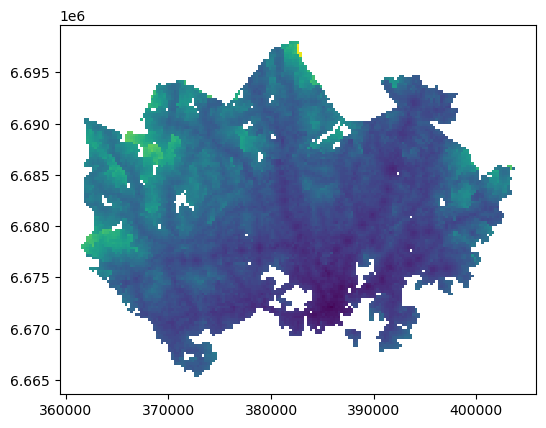

In [4]:
grid.plot(column="pt_r_t")

_**Figure 8.1**. Simple static map plotted using `geopandas`. The color gradient represents travel times by public transport to the central railway station in Helsinki, Finland from across the region. Data source: Tenkanen & Toivonen 2020._

What we have here is a `choropleth map` where the colors of each grid square polygon are based on values from the column `pt_r_t`. We will see later how to change the classification scheme that determines the assignment of values to each class for the visualization. 

### Re-projecting data (if needed)

The power of geographic information often relies on overlaying multiple features and exploring their spatial relations. Here, we can visualize the transport network data on top of the travel time information to add spatial context in our map. In order to plot multiple layers in the same figure, the first thing is to check the coordinate reference system (CRS) of each layer and check that they match:

In [5]:
# Check the crs of each layer
print(grid.crs)
print(metro.crs)
print(train.crs)

EPSG:3067
EPSG:4326
EPSG:4326


All layers have a defined CRS, but we can see that the coordinate reference system definitions don't match, which is a problem for plotting our map. The grid is in ETRS89 / TM35FIN (EPSG:3067), which is an appropriate map projection for visualizing data from Finland. Roads and the metro are in WGS 84 (EPSG:4326) meaning that the coordinates are in latitudes and longitudes. Let's see what happens if trying to plot all three layers in the same figure without re-projecting the data:

<Axes: >

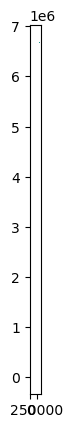

In [6]:
ax = grid.plot(column="pt_r_t")
train.plot(ax=ax)
metro.plot(ax=ax)

_**Figure 8.2**. Failed attempt to plot a static map with multiple layers._

We need to re-project the data in order to get the layers in the same coordinate space. Here, we can re-project the linear features (train and metro) from WGS 84 to ETRS89 / TM35FIN (EPSG:3067). While doing this, we can get the crs definition based on the grid layer ensuring that the crs definitions will be identical.

In [7]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
train = train.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

Now the layers should be in the same coordinate reference system:

In [8]:
# Check the crs of each layer
print(grid.crs)
print(metro.crs)
print(train.crs)

EPSG:3067
EPSG:3067
EPSG:3067


Once the data are in the same projection, we can plot them on a map. First, we plot one of the layers and store that plot object in the variable `ax` (referring to the subplot object) and use this for plotting the other layers in the same subplot:

<Axes: >

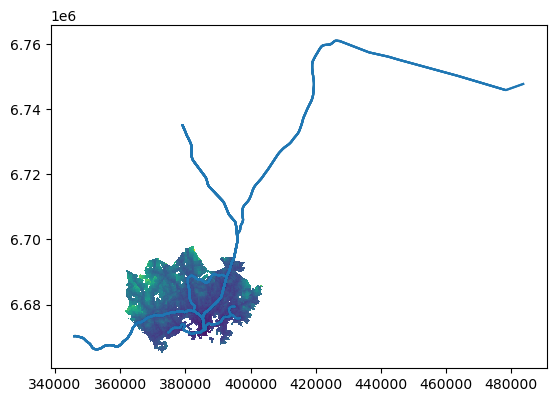

In [9]:
ax = grid.plot(column="pt_r_t")
train.plot(ax=ax)
metro.plot(ax=ax)

_**Figure 8.3**. Static map with multiple layers displaying the original data extent. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

### Customizing our map
Now our layers are nicely aligned, but the map needs some further improvement. Some map elements such as color and linewidth are still easy to configure directly via `geopandas`, but we need `matplotlib.pyplot` for controlling other features related to the layout. Let's apply the following changes to our plot: 

- Changing the colors of the choropleth map using the `cmap` parameter. See available [colormap options from matplotlib documentation](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib) [^matplotlib_colormaps].
- Changing line colors using the `color` parameter. See [color options from matplotlib pyplot documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors) [^matplotlib_colors].
- Changing the `linewidth` of line features.
- Adding transparency using the `alpha` parameter (this parameter ranges from 0 to 1 where 0 is fully transparent).
- Cropping the figure by adjusting the view limit of each axis. We can get the desired plot extent from the `total_bounds` of the grid layer. This way we don't need to separately crop the train line that goes outside the extent of the grid data.
- Using a `tight_layout`to adjust the subplot to fit in the figure area via `matplotlib`.
- Removing the frame and and axis labels through setting x- and y- axis on or off via `matplotlib`.

Finally, we can save the figure as PNG image.

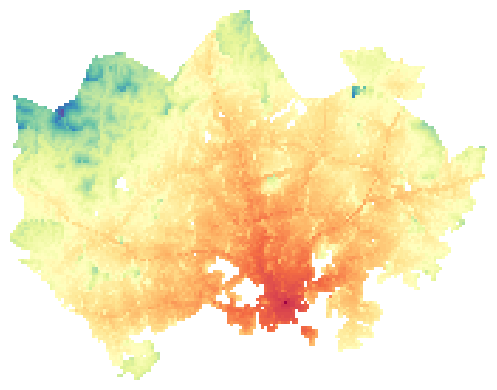

In [10]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times
grid.plot(ax=ax, 
          column="car_r_t", 
          cmap="Spectral"
          )

# Set axis view limits based on the total bounds of the grid layer
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])

# Set the x and y axis off 
plt.axis("off")

# Adjust padding around the subplot
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

_**Figure 8.4**. Static map with multiple layers with adjusted extent and colors. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

### Adding a legend and a scalebar

Legend and scalebar are basic elements of an informative map. You don't necessarily always need neither of them, but here both legend and a scalebar would add informative value to our map and help to understand the value range and geographic scale. 

We can add a map legend directly when plotting the `GeoDataFrame` through setting `legend=True`.  Additional keywords can be added through `legend_kwds`. Here, our legend is a [colorbar object](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html) [^matplotlib_colorbar] and the legend keyword arguments will control how the colorbar looks. For example, we can add a `label` for our colorbar legend. For additional legend options, have a look at [`geopandas` mapping tools](https://geopandas.org/en/stable/docs/user_guide/mapping.html) [^geopandas_mappingtools] and [`matplotlib` legend guide](https://matplotlib.org/tutorials/intermediate/legend_guide.html) [^matplotlib_legend].

A scalebar can be added using the `maplotlib-scalebar` library, which needs to be installed separately in addition to `matplotlib`. Adding a scalebar is easy as long as the data are in a projected metric coordinate reference system. The ScaleBar object only requires one parameter, `dx`, which indicates a size of one pixel in real world units. For a metric crs, we can simply set `dx=1`. For tips on how to customize the scalebar, have a look at [`geopandas` examples gallery](https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html#Adding-a-scale-bar-to-a-matplotlib-plot) [^geopandas_scalebar_examples]

In [11]:
from matplotlib_scalebar.scalebar import ScaleBar

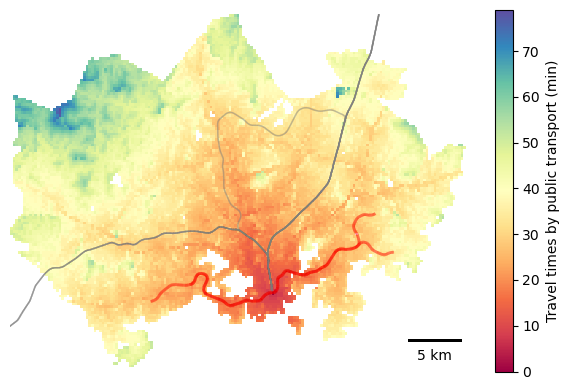

In [12]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times
grid.plot(ax=ax, 
          column="car_r_t", 
          cmap="Spectral",
          legend=True,
          legend_kwds={"label": "Travel times by public transport (min)"},
          )

# Add roads and change the color, linewidth and and transparency
train.plot(ax=ax, color="grey", linewidth=1, alpha=0.1)

# Add metro and change the color, linewidth and and transparency
metro.plot(ax=ax, color="red", linewidth=2, alpha=0.1)

# Set axis view limits based on the total bounds of the grid layer
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])

# Add scalebar
ax.add_artist(ScaleBar(dx=1, location="lower right"))

# Set the x and y axis off 
plt.axis("off")

# Adjust padding around the subplot
plt.tight_layout()

_**Figure 8.5**. Static map with multiple layers and a scale bar. Data source: Tenkanen & Toivonen 2020; Helsinki Region Transport 2024._

## Classification schemes

Next, we will see how we can further control the way in which the travel time values are displayed using classification schemes. With choropleth maps, it is essential to pay attention to the classification scheme that is used to display the values. We will now learn how to use classification schemes from the [PySAL](https://pysal.org/) [^pysal] [`mapclassify` library](https://pysal.org/mapclassify/) [^mapclassify] to classify quantitative data into multiple classes for visualization purposes. These classification schemes can be used directly when plotting data in `geopandas` as long as `mapclassify` package is also installed.  Available classification schemes include: 

- box_plot
- equal_interval
- fisher_jenks
- fisher_jenks_sampled
- headtail_breaks
- jenks_caspall
- jenks_caspall_forced
- jenks_caspall_sampled
- max_p_classifier
- maximum_breaks
- natural_breaks
- quantiles
- percentiles
- std_mean
- user_defined
  
Each classification scheme partitions the data into mutually exclusive groups that define how the values are displayed on the map. See {cite}`Rey_et_al_2023` for a thorough introduction on the mathematics behind each classification scheme. Choosing an adequate classification scheme and number of classes depends on the message we want to convey with our map and the underlying distribution of the data. 

### Explore the classifiers

When visualizing travel times we want our map to show regional differences in the travel times in an intuitive way while avoiding excess detail. We might want to, e.g., highlight more the differences in relatively short travel times versus very long travel times. To help us choose an adequate classification scheme, let's have a look at the distribution of the public transport travel times through checking the histogram and descriptive statistics. A histogram is a graphic representation of the distribution of the data. Descriptive statistics summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding `NaN` values. While looking at the histogram, remember that each observation is one 250 m x 250 m grid square in the Helsinki region and the histogram shows the distribution of travel times to the central railway station across the whole region. 

For exploring the different classification schemes, let's create a `pandas` `Series` without `NaN` values.

In [13]:
# Getting a data Series withouth NaN values
travel_times = grid.loc[grid["pt_r_t"].notnull(), "pt_r_t"]

<Axes: ylabel='Frequency'>

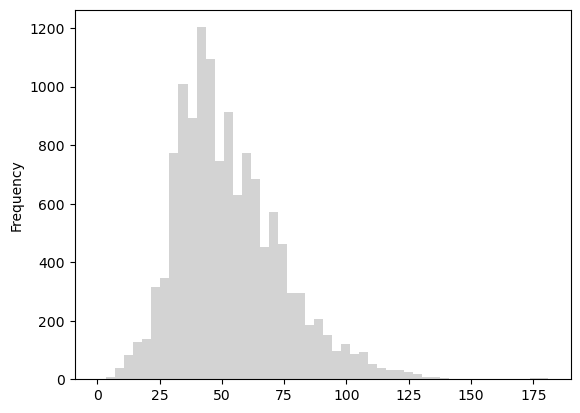

In [14]:
travel_times.plot.hist(bins=50, color="lightgray")

_**Figure 8.6**. Histogram of the travel time values. Data source: Tenkanen & Toivonen 2020._

In [15]:
travel_times.describe()

count    13020.000000
mean        53.124654
std         21.295944
min          0.000000
25%         38.000000
50%         49.000000
75%         65.000000
max        181.000000
Name: pt_r_t, dtype: float64

The maximum travel time to the central railway station by public transport (including time for walking) is 181 minutes, i.e. over three hours. Most of the travel times range between 38 and 65 minutes with an average travel time of 53 minutes. Looking at the histogram (Figure 8.6), we can tell than only a handful of grid squares have more than two hour travel times to the central railway station. These grid squares are most likely located in rather inaccessible places in terms of public transport accessibility. 

Let's have a closer look at how these `mapclassify` classifiers work and try out different classification schemes for visualizing the public transport traveltimes. In the interactive version of this book, you can try out different numbers of classes and different classification schemes.

#### Natural breaks

First, let's try out natural breaks classifier that tries to split the values into natural clusters. The number of observations per bin may vary according to the distribution of the data.

In [16]:
import mapclassify
mapclassify.NaturalBreaks(y=travel_times, k=10)

NaturalBreaks

    Interval       Count
------------------------
[  0.00,  23.00] |   524
( 23.00,  34.00] |  1769
( 34.00,  42.00] |  2360
( 42.00,  50.00] |  2128
( 50.00,  59.00] |  1918
( 59.00,  69.00] |  1704
( 69.00,  79.00] |  1161
( 79.00,  92.00] |   764
( 92.00, 111.00] |   501
(111.00, 181.00] |   191

It's possible to extract the threshold values into an array:

In [17]:
mapclassify.NaturalBreaks(y=travel_times, k=10).bins

array([ 23.,  34.,  43.,  52.,  60.,  70.,  81.,  94., 113., 181.])

We can further explore the classification on top of the histogram:

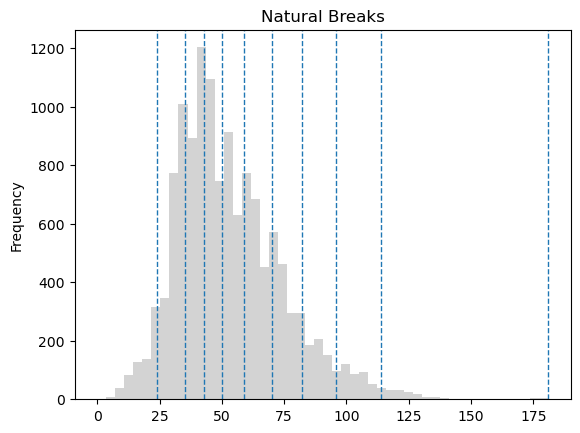

In [18]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.NaturalBreaks(y=travel_times, k=10)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, color="lightgray", title="Natural Breaks")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point,  linestyle="dashed", linewidth=1)

_**Figure 8.7**. Histogram of the travel time values with natural breaks classification into 10 groups. Data source: Tenkanen & Toivonen 2020._

Finally, we can visualize our data using the classification scheme through adding the `scheme` option, while the parameter `k` defines the number of classess to use. Note that the syntax via `geopandas` differs a bit from `mapclassify`. We can control the position and title of the legend using `matplotlib` tools trough changing the properties of the legend object. 

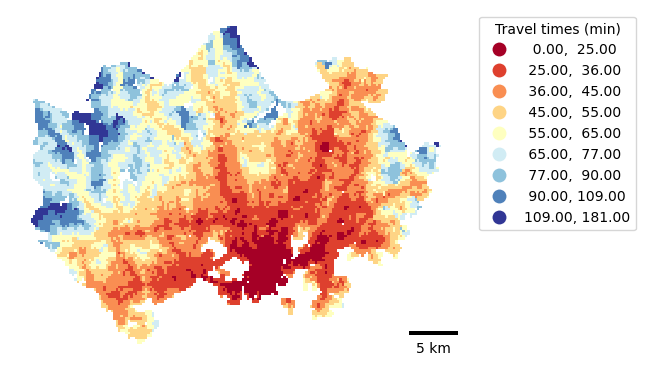

In [19]:
# Plot the data using "Natural Breaks" classification
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    legend=True,
    legend_kwds={"title": "Travel times (min)",
                 "bbox_to_anchor": (1.4, 1)
                },
)

# Add scalebar
ax.add_artist(ScaleBar(1, location="lower right"))

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

_**Figure 8.8**. Static map of travel times visualized using the natural breaks classification scheme. Data source: Tenkanen & Toivonen 2020._

In comparison to the previous maps, the differences in travel times are now more pronounced highlighting lower travel times near the central railway station. Notice also that we now have a different type of map legend that shows the associated class bins, now that we used a classification scheme. Here, we set the title and location of the legend using `legend_kwds` at the same time when plotting the map. We use `bbox_to_anchor` to position the legend item so that it does not overlap and cover our map extent.  An alternative way to achieve the same thing would be to add `ax.get_legend().set_bbox_to_anchor((1.4, 1))` after plotting the data via `geopandas`. For further tips on customizing choropleth map legends, have a look at [`geopandas examples gallery`](https://geopandas.org/en/stable/gallery/choro_legends.html) [^geopandas_choro_legends].

#### Quantiles 

Next, let's explore the quantiles classification that splits the data so that each class as an equal number of observations. 

In [20]:
mapclassify.Quantiles(y=travel_times, k=10)

Quantiles

    Interval       Count
------------------------
[  0.00,  30.00] |  1406
( 30.00,  36.00] |  1436
( 36.00,  40.00] |  1242
( 40.00,  44.00] |  1135
( 44.00,  49.00] |  1319
( 49.00,  55.00] |  1392
( 55.00,  62.00] |  1342
( 62.00,  70.00] |  1265
( 70.00,  81.00] |  1190
( 81.00, 181.00] |  1293

Notice that the numerical range of the groups created using the quantiles classification scheme may vary greatly depending on the distribution of the data. In our example, some classes have more than 30 min interval, while others less than 10 minutes. The default number of classes is five (quintiles), but you can set the desired number of classes using the `k` parameter. In the interactive version of the book, you can try increasing the number of classes and see what happens. 

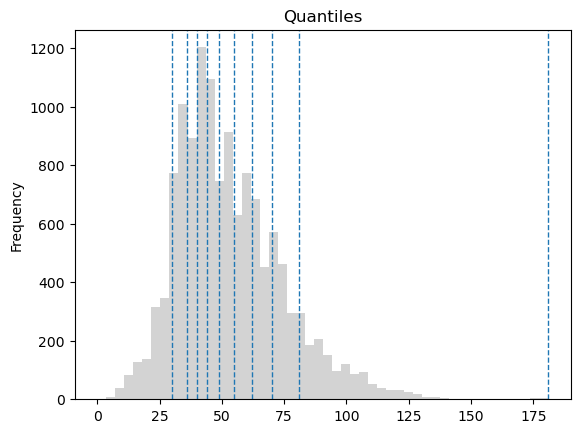

In [21]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.Quantiles(y=travel_times, k=10)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, color="lightgray", title="Quantiles")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 8.9**. Histogram of the travel time values with Quantile classification into 10 groups. Data source: Tenkanen & Toivonen 2020._

If comparing the histograms of natural breaks and quantile classifications, we can observe that natural breaks might work better to display differences in the data values across the whole data range, while quantiles would help distinguishing differences around the central peak of the data distribution. However, neither of the classification schemes display differences in short, less than 25 minute travel times which might be important for making an informative map. Also, we might want to have round numbers for our class values to facilitate quick and intuitive interpretation. 

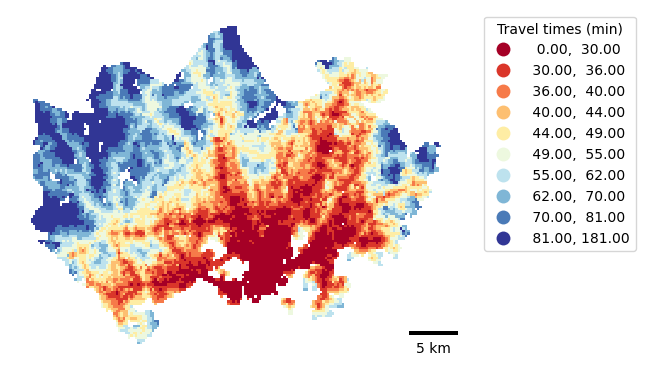

In [22]:
# Plot the data using "Natural Breaks" classification
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="quantiles",
    k=10,
    legend=True,
    legend_kwds={"title": "Travel times (min)",
                 "bbox_to_anchor": (1.4, 1)
                },
)

# Add scalebar
ax.add_artist(ScaleBar(1, location="lower right"))

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()


#### Pretty breaks

The pretty breaks classification shceme rounds the class break values and divides the range equally to creat nice and pretty intervals. 

In [23]:
mapclassify.PrettyBreaks(y=travel_times, k=10)

Pretty

    Interval       Count
------------------------
[  0.00,  20.00] |   335
( 20.00,  40.00] |  3749
( 40.00,  60.00] |  4822
( 60.00,  80.00] |  2740
( 80.00, 100.00] |   933
(100.00, 120.00] |   351
(120.00, 140.00] |    84
(140.00, 160.00] |     0
(160.00, 180.00] |     5
(180.00, 200.00] |     1

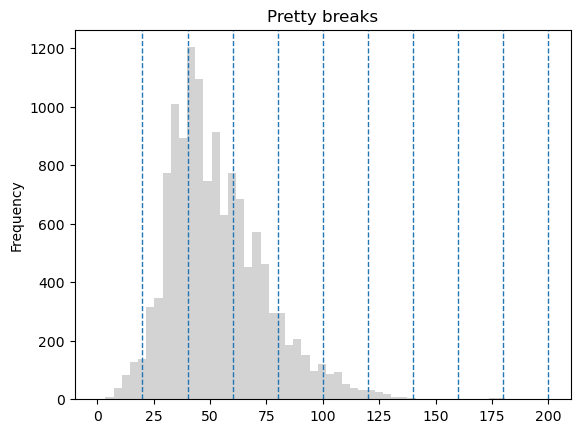

In [24]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.PrettyBreaks(y=travel_times, k=10)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, color="lightgray", title="Pretty breaks")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 8.10**. Histogram of the travel time values with 10 pretty breaks. Data source: Tenkanen & Toivonen 2020._

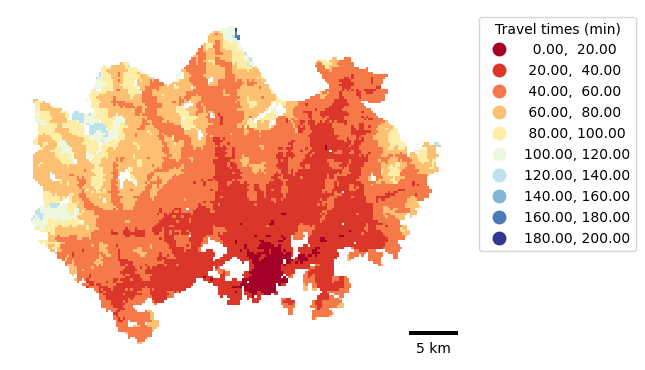

In [25]:
# Plot the data using "Natural Breaks" classification
ax = grid.plot(
    figsize=(6, 4),
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="prettybreaks",
    k=10,
    legend=True,
    legend_kwds={"title": "Travel times (min)",
                 "bbox_to_anchor": (1.4, 1)
                },
)

# Add scalebar
ax.add_artist(ScaleBar(1, location="lower right"))

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()



Regardless of the number of classes, pretty breaks is not ideal for our data as it fails to capture the variation in the data. Compared to this map, the previous two versions using natural breaks and quantiles provide a more informative view of the travel times.

#### Question 8.1

Select another column from the data (for example, travel times by car: `car_r_t`) and visualize a thematic map using one of the available classification schemes and save it as a PNG image file.

In [26]:
# Use this cell to enter your solution.

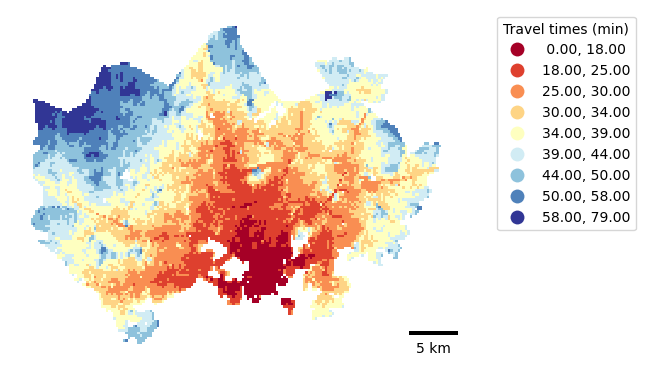

In [27]:
# Solution

# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(6, 4))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax,
          column="car_r_t",
          cmap="RdYlBu",
          linewidth=0,
          scheme="FisherJenks",
          k=9,
          legend=True,
          legend_kwds={"title": "Travel times (min)",
                 "bbox_to_anchor": (1.4, 1)}
         )


# Add scalebar
ax.add_artist(ScaleBar(1, location="lower right"))

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map2.png"
plt.savefig(outfp, dpi=300)

### Custom map classification

For travel time data, having fixed intervals with gradually increasing travel times is an intuitive way of displaying the phenomena. The pretty breaks classification scheme achieves something like this, but it did not work perfectly for our data. Using `mapclassify`, we can create a custom classification and select which class interval values to use. This way, we can try to better capture the variation in the data while using rounded-up intuitive class break values. It would be meaningful to show differences between the typical travel times, but avoid having classes distinguishing between long travel times. To achieve this, we'll create a custom classifier with fixed 10-minute intervals up to 90 minutes, allowing us to emphasize variations around the central peak of the distribution.

In [28]:
break_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
classifier = mapclassify.UserDefined(y=travel_times, bins=break_values)
classifier

UserDefined

    Interval       Count
------------------------
[  0.00,  10.00] |    49
( 10.00,  20.00] |   286
( 20.00,  30.00] |  1071
( 30.00,  40.00] |  2678
( 40.00,  50.00] |  2697
( 50.00,  60.00] |  2125
( 60.00,  70.00] |  1631
( 70.00,  80.00] |  1109
( 80.00,  90.00] |   603
( 90.00, 181.00] |   771

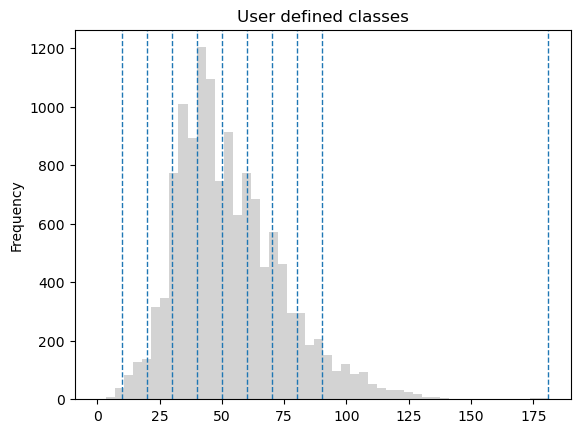

In [29]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.UserDefined(y=travel_times, bins=break_values)

# Plot histogram for public transport rush hour travel time
grid["pt_r_t"].plot.hist(bins=50, title="User defined classes", color="lightgray")

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, linestyle="dashed", linewidth=1)

_**Figure 8.11**. Histogram of the travel time values with user defined class breaks. Data source: Tenkanen & Toivonen 2020._

When plotting the map, we can pass the break values using `classification_kwds`. For a final touch, we can plot two subplots side by side displaying travel times by different modes of transport using our custom classifier:

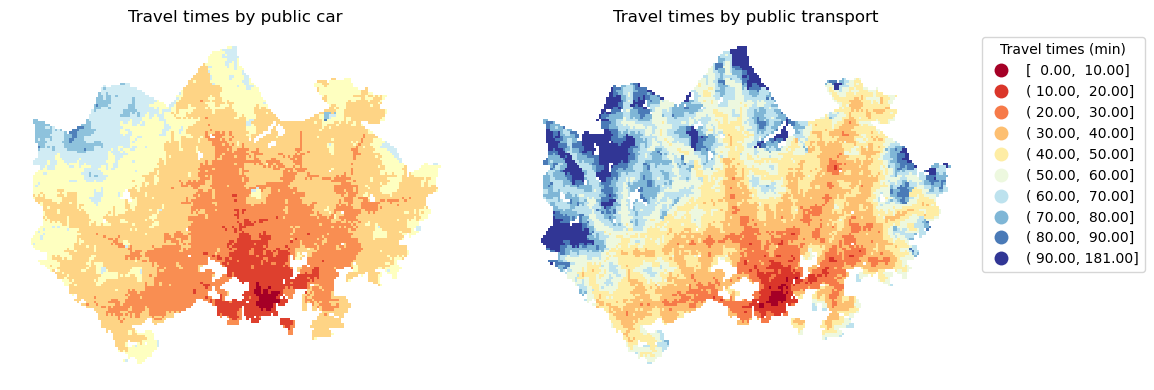

In [30]:
# Create one subplot. Control figure size in here.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=axs[0],
          column="car_r_t",
          cmap="RdYlBu",
          linewidth=0,
          scheme="UserDefined",
          classification_kwds={'bins': break_values},
        )

grid.plot(ax=axs[1],
          column="pt_r_t",
          cmap="RdYlBu",
          linewidth=0,
          scheme="UserDefined",
          classification_kwds={'bins': break_values},
          legend=True,
          legend_kwds={"title": "Travel times (min)",
                       "bbox_to_anchor": (1.4, 1),
                       "interval": True},
          label="Travel times by public transport"
        )

axs[0].set_title("Travel times by public car")
axs[1].set_title("Travel times by public transport")

# Set the x and y axis off and adjust padding around the subplot
axs[0].axis("off")
axs[1].axis("off")

plt.tight_layout()

_**Figure 8.12**. Static map of travel times by car and public transport using a custom classification scheme. Data source: Tenkanen & Toivonen 2020._

## Adding a basemap

Let's now forget about separate transport network layers we used previously and add spatial context using basemaps from online sources. Basemaps might feature satellite imagery or a readily visualized bacground maps displaying various essential features such as streets, administrative boundaries, water bodies and so on.  We can use `contextily` together with `geopandas` and `matplotlib` to fetch map tiles as basemaps for our static maps. Bacground maps are available via `contextily` from various providers: 

In [31]:
print(list(ctx.providers))

['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey']


For most of the providers, there are multiple style options available. Here is an example for available OpenStreetMap visualizations: 


In [32]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'CAT'])

Map tiles are typically distributed in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/). We either need to re-project our data before plotting, or set the desired coordinate reference system directly when adding the basemap using contextily. Let's plot our data using `geopandas` and add a default basemap for our plot using `contextily` using in the local EPSG:3067 projection:

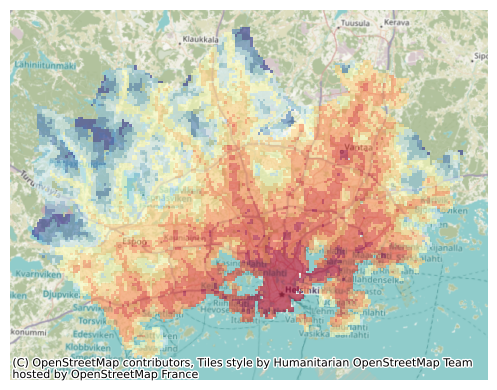

In [33]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    alpha=0.6,
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap and set crs
ctx.add_basemap(ax, crs=grid.crs)

_**Figure 8.13**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

We can change the background map easily using the `source` -parameter when adding the basemap. At the same time we can customize the credits that are displayed on the map. `Contextily` automatically adds credits for the bacground map. We can modify the credits text and add attribution also to the travel time data (Tenkanen & Toivonen 2020) in addition to the credits to OpenStreetMap contributors.

In [34]:
credits = "Travel time data by Tenkanen & Toivonen (2020),\n Map Data © OpenStreetMap contributors"

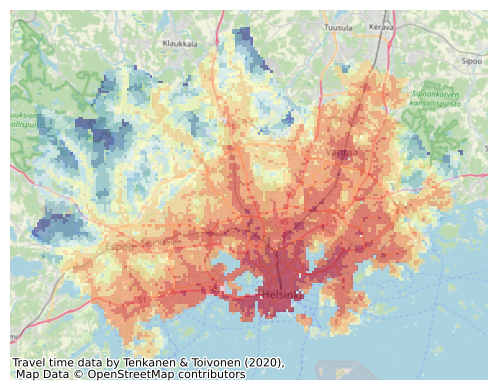

In [35]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(ax=ax,
          column="pt_r_t",
          cmap="RdYlBu",
          linewidth=0,
          scheme="Natural_Breaks",
          k=9,
          alpha=0.6,
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

_**Figure 8.14**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

 Let's take a subset of our data to see a bit better the background map characteristics. We can, for example, visualize grid squares from where the central railway station can be reached in less than 15 minutes to get a zoomed-in view of the map:

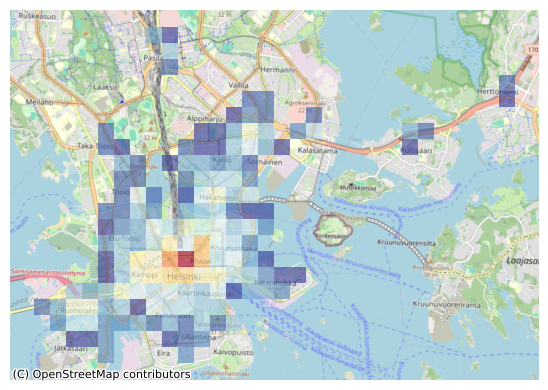

In [40]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

#  Plot only a subset of the data
grid.loc[(grid["pt_r_t"] <=15)].plot(ax=ax, column="pt_r_t", cmap="RdYlBu", linewidth=0, alpha=0.6)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

_**Figure 8.15**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

Now our map has much more details as the zoom level of the background map is larger. This type of map might be useful for quick data exploration purposes. For example, we can observe that most of the short travel times are located in the city center, while the central railway station is also accessible within 20 minutes public transport travel times from individual locations a bit further away along the train and metro lines.

`Contextily` sets the zoom level automatically but it is also possible to control the zoom level manually. The zoom level is by default specified as `auto` and it can be changed by passing in a specified [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have). Let's try reducing the level of detail from our map by passing `zoom=12`:


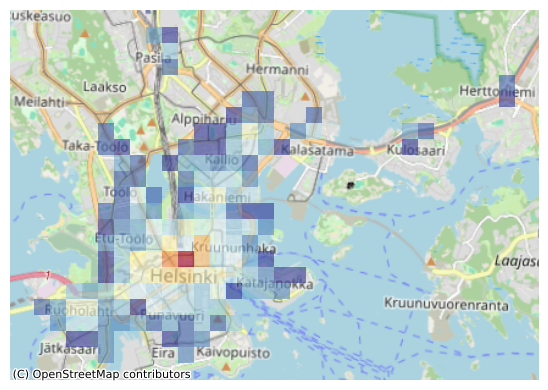

In [42]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

#  Plot only a subset of the data
grid.loc[(grid["pt_r_t"] <=15)].plot(ax=ax, column="pt_r_t", cmap="RdYlBu", linewidth=0, alpha=0.6)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

_**Figure 8.16**. Static map of travel times visualized on top of a basemap. Data source: Tenkanen & Toivonen 2020; OpenStreetMap contributors 2025._

With this zoom setting, place names in the bacground map become larger and more readable. 

#### Question 8.2

Explore different background map options and make a final visualization of our travel time data with a basemap.

In [38]:
# Use this cell to enter your solution.

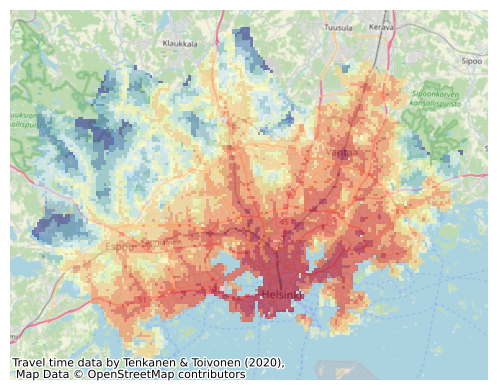

In [43]:
# Solution

# Control figure size in here
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
grid.plot(
    ax=ax,
    column="pt_r_t",
    cmap="RdYlBu",
    linewidth=0,
    scheme="Natural_Breaks",
    k=9,
    alpha=0.6,
    legend_kwds={"title": "Travel times (min)",
    "bbox_to_anchor": (1.4, 1)}
)

# Set the x and y axis off and adjust padding around the subplot
plt.axis("off")
plt.tight_layout()

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, crs=grid.crs)

## Footnotes
[^geopandas_mappingtools]: <https://geopandas.org/en/stable/docs/user_guide/mapping.html> 
[^matplotlib_pyplot]: <https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html> 
[^contextily]: <https://github.com/darribas/contextily>
[^HSL_opendata]: <https://www.avoindata.fi/data/en_GB/dataset/hsl-n-linjat>
[^matplotlib_colormaps]: <https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib>
[^matplotlib_colors]: <https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors>
[^matplotlib_colorbar]: <https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html>
[^matplotlib_legend]: <https://matplotlib.org/tutorials/intermediate/legend_guide.html>
[^geopandas_scalebar_examples] <https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html#Adding-a-scale-bar-to-a-matplotlib-plot>
[^pysal]: <https://pysal.org/> 
[^mapclassify]: <https://pysal.org/mapclassify/>
[^geopandas_choro_legends]: <https://geopandas.org/en/stable/gallery/choro_legends.html>